**Model**

In [1]:
#Imports

from pathlib import Path
import torch, os
import matplotlib.pyplot as plt
import torchvision.transforms as t
from torch import nn, optim
import cv2

In [2]:
# Data preprocessing
train_path = Path.cwd() / "train"
test_path = Path.cwd() / "test"

from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
#from natsort import natsorted

class Data(Dataset):
    def __init__(self, main_dir, gray_transform, img_transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.gray_transform = gray_transform
        self.img_transform = img_transform
        # List all images in folder and count them
        self.all_imgs = os.listdir(main_dir)
        #self.total_imgs = natsorted(all_imgs)
    
    def __len__(self):
        # Return the previously computed number of images
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])

        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        # Apply the transformations
        gray_image = self.gray_transform(image)
        color_image = self.img_transform(image)
        s = color_image.shape
        odd_crop = t.CenterCrop((s[1]-s[1]%2,s[2]-s[2]%2))
        gray_image = odd_crop(gray_image)
        color_image = odd_crop(color_image)
        return gray_image, color_image

from torchvision.transforms import Compose
i_transform = Compose([t.ToTensor()])
g_transform = Compose([t.ToTensor(), t.Grayscale()])
# YOUR CODE HERE

example_dataset = Data(train_path, g_transform, i_transform)
g_img, i_img = example_dataset[3]
print(len(example_dataset))


3455


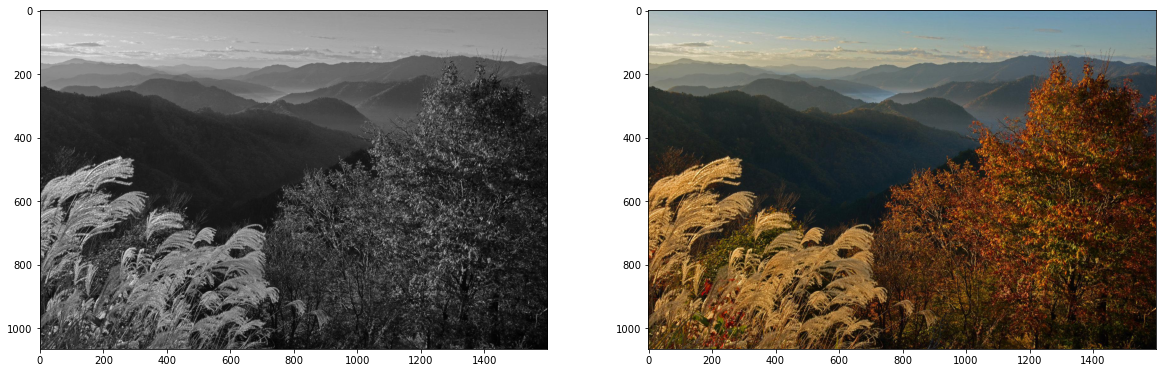

In [3]:
def display_image(axis, image_tensor):
    """Display a tensor as an image
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0)
    axis.imshow(image_data, cmap='gray')
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.

def display_comp(g_img, img):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    display_image(axes[0], g_img)
    display_image(axes[1], img)
    plt.show()

# Example usage
#_, axis = plt.subplots()
some_random_index = 300
g_img, c_img = example_dataset[some_random_index]
display_comp(g_img, c_img)

In [16]:
from torch.utils.data import DataLoader

batch_size = 4
train_dataset = Data(train_path, g_transform, i_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Data(test_path, g_transform, i_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [17]:
from torch import nn, optim
import torch.nn.functional as F

## CNN MODULE
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3, padding = 1)
        self.conv4 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3, padding = 1)
        self.pool = nn.MaxPool2d(2, stride = 2)
        self.unpool = nn.MaxUnpool2d(2, stride = 2)
        
        self.up = nn.Upsample(scale_factor=(2,2))
        #self.norm = nn.BatchNorm2d(128)
        
    def forward(self, input_batch):
        x = input_batch
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        #x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.up(x)
        
        return x

model = CNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

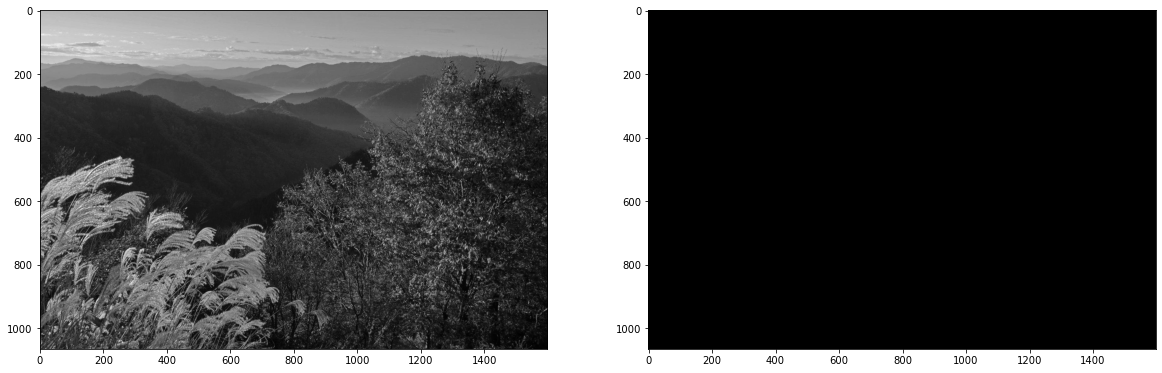

In [18]:
some_random_index = 300
g_img, c_img = example_dataset[some_random_index]
r_img = torch.unsqueeze(g_img, 0)
r_img = model.forward(r_img)
r_img = r_img.detach()
r_img = torch.squeeze(r_img)
display_comp(g_img, r_img.detach())


In [21]:
for epoch in range(1):
    # Compute predictions and back-prop in the training set
    losses = []
    n_correct = 0
    iter = 0
    for b_x, b_y in train_dataloader:
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        iter += 1
        if iter%10 == 0: 
            print(f'{iter} batches trained')
            
        if iter == 100: 
            break
        
        
        #hard_preds = pred.argmax(dim=1)
        #n_correct += (pred.argmax(dim=1) == b_y).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    #train_accuracy = n_correct/len(train_dataset)
    train_avg_loss = sum(losses)/len(losses)    
    
    # Compute predictions in the validation set (with adagrad deactivated)
    losses = []
    n_correct = 0
    with torch.no_grad():
        iter = 0
        for b_x, b_y in val_dataloader:
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            
            iter += 1
            if iter%10 == 0: 
                print(f'{iter} batches validated')
            
            if iter == 50: 
                break
            
            #hard_preds = pred.argmax(dim=1)
            #n_correct += (pred.argmax(dim=1) == b_y).sum().item()
        #val_accuracy = n_correct/len(test_dataset)
        val_avg_loss = sum(losses)/len(losses)      
        
        
    display_str = 'Epoch {}'
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss)) 

RuntimeError: stack expects each tensor to be equal size, but got [1, 682, 1024] at entry 0 and [1, 1064, 1600] at entry 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


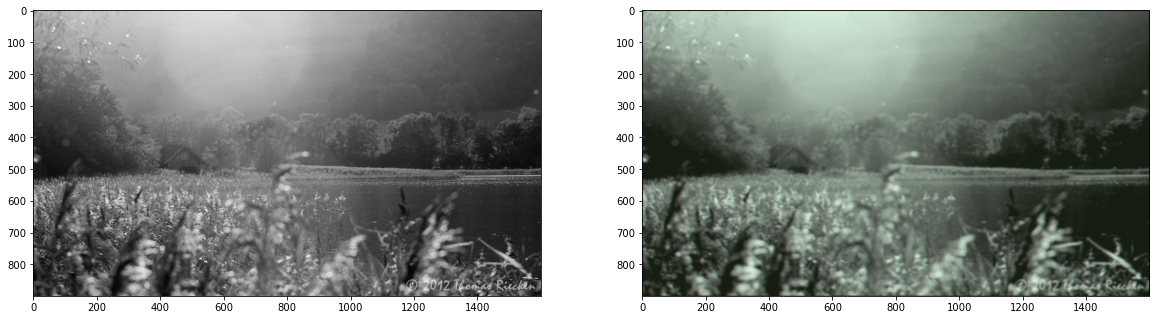

In [15]:
some_random_index = 429
g_img, c_img = example_dataset[some_random_index]
r_img = torch.unsqueeze(g_img, 0)
r_img = model.forward(r_img)
r_img = r_img.detach()
r_img = torch.squeeze(r_img)
display_comp(g_img, r_img.detach())